# Изучение закономерностей, определяющих успешность игр

В нашем распоряжении исторические данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы.

Попробуем выявить определяющие успешность игры закономерности, чтобы сделать ставку на потенциально популярный продукт.

## Изучение данных из файла

Составим первое впечатление о таблицах. Испортируем все библиотеки, которые в дальнейшем будем использовать, прочтем файлы.

In [1]:
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

data = pd.read_csv('/datasets/games.csv')
# выведем первые 5 строк и информацию о таблице
display(data.head())
data.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В таблице 11 столбцов и 16715 строк.

Согласно документации к данным:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Вывод

Для дальнейшей анализа данные необходимо обработать:
- заполнить пропущенные значения (при необходимости)
- удалить дубликаты (если они имеются)
- привести названия столбцов к нижнему регистру
- преобразовать типы


## Подготовка данных

In [2]:
# приведем названия столбцов к нижнему регистру
data.columns = [column.lower() for column in data.columns]

Заменим типы данных в столбцах:
- year_of_release на формат даты
- user_score на float, т.к. столбцес содержит числовые данные

In [3]:
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y')

Перевести столбец user_score в формат float сразу не удается, т.к. некоторые строки содержат значение 'tbd', что значит 'будет определено' - заменим значение в данных строках на nan, а затем поменяем формат столбца.

In [4]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')

data['user_score'] = pd.to_numeric(data['user_score'])


In [5]:
# напишем функцию для определения числа пропусков
def passage(columns):
    kol = len(data.loc[data[columns].isna(), columns])
    percent = kol/ len(data)
    print(f'{columns}: количество пропусков - {kol}, процент пропусков - {percent: 0.1%} ')
    
for column in data.columns:
    passage(column)

name: количество пропусков - 2, процент пропусков -  0.0% 
platform: количество пропусков - 0, процент пропусков -  0.0% 
year_of_release: количество пропусков - 269, процент пропусков -  1.6% 
genre: количество пропусков - 2, процент пропусков -  0.0% 
na_sales: количество пропусков - 0, процент пропусков -  0.0% 
eu_sales: количество пропусков - 0, процент пропусков -  0.0% 
jp_sales: количество пропусков - 0, процент пропусков -  0.0% 
other_sales: количество пропусков - 0, процент пропусков -  0.0% 
critic_score: количество пропусков - 8578, процент пропусков -  51.3% 
user_score: количество пропусков - 9125, процент пропусков -  54.6% 
rating: количество пропусков - 6766, процент пропусков -  40.5% 


В столбцах name и genre пропущено по 2 строки со значениями - посмотрим на них.

In [6]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993-01-01,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993-01-01,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Как мы видим - эти пропущенные строки совпадают для обоих столбцов, также в них пропущены значения и по 3 крайним правым стобцам. Удалим эти строки.

% пропусков в столбце year_of_release небольшой - удалим эти строки тоже.

In [7]:
data = data[~data['name'].isna()]

data = data[~data['year_of_release'].isna()]

Заполнение пропусков в столбцах с рейтингами (3 крайних правых) нежелательно, т.к. это может повлечь за собой искажение результатов дальнейшего анализа ввиду того, что процент пропусков очень большой.

In [8]:
# проверим, есть ли в данных явные дубликаты
data.duplicated().sum()

0

In [9]:
# добавим столбец total_sales с суммарными продажами по всем регионам
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

### Вывод

При подготовке данных мы:
- заменили типы данных у 2 столбцов : year_of_release на формат даты, user_score на float 
- привели названия столбцов к нижнему регистру
- удалили строки с пропущенными значениями в стобцах name, genre, year_of_release
- оставили пропуски в столбцах critic_score, score_score, rating (чтобы не исказались данные при дальнейшем анализе)
- добавили дополнительный столбце с суммарными продажами total_sales 

Таким обраом наши данные готовы для анализа.

## Исследовательский анализ данных

Для начала посмотрим, сколько игр выпускалось за каждый год, чтобы понять важны ли нам все данные или можем ограничиться их частью.

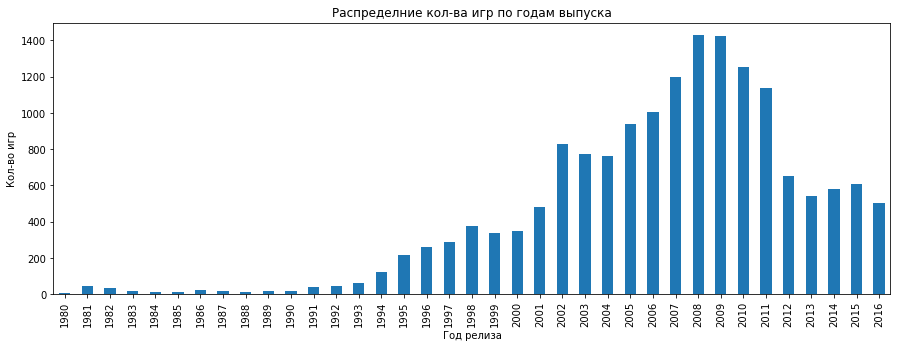

In [10]:
data['year_of_release'] = pd.DatetimeIndex(data['year_of_release']).year

data.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(15, 5))
plt.title("Распределние кол-ва игр по годам выпуска")
plt.xlabel("Год релиза")
plt.ylabel('Кол-во игр')
plt.show()

По распределению выше видим, что рост выпуска игр на рынок начался с 1994 года, при этом только с 2000х годов пошел резки скачок по выпуску.

Посмотрим, как менялись продажи по платформам.

In [11]:
platforms = data.groupby('platform')['total_sales'].sum().reset_index().sort_values(by='total_sales',ascending=False).reset_index(drop=True).head(10)

# создадим список из 10 платфор с самыми большими суммарными продажами
top_platform = []
for platform in platforms['platform']:
    top_platform.append(platform)

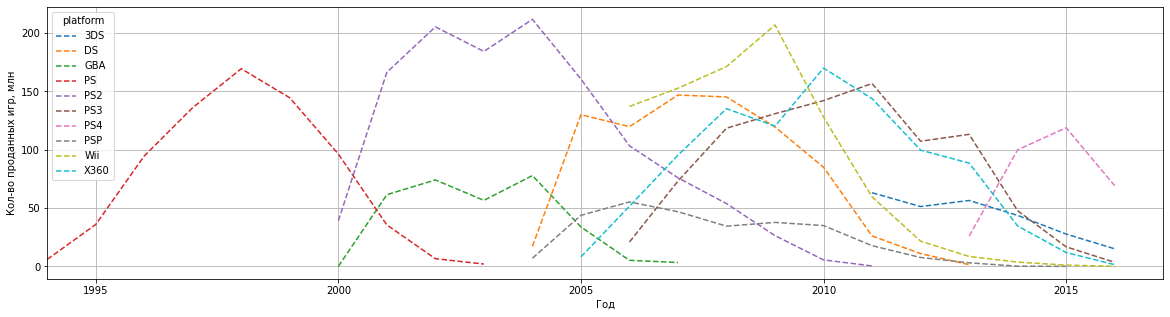

In [12]:
# отобразим данные на графике
pivot_top_platform = data.query("platform in @top_platform").pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
pivot_top_platform.plot(figsize=(20, 5), style='--', grid=True)
plt.xlim(1994, 2017)
plt.xlabel('Год')
plt.ylabel('Кол-во проданных игр, млн')
plt.show()

Из графика видно, что платформы появляются и исчезают. Рассчитаем средний срок существования платформ.

In [13]:
total, count = 0, 0
for platform in top_platform:
    total +=(~pivot_top_platform.reset_index()[platform].isna()).sum()
    count +=1

print("Средний срок существования платформ", total/count, "лет")


Средний срок существования платформ 9.7 лет


Ввиду того, что средний срок существования платформ приблизительно равен 10 лет - в дальнейшем анилизе будем учитывать данные только с 2007 года.

In [14]:
# найдем топ самых прибыльных за последние 10 лет платформ
platforms = data.query('year_of_release >= 2007').pivot_table(index='platform', values='total_sales', aggfunc='sum').reset_index().sort_values(by='total_sales', ascending=False).reset_index(drop=True).head(10)

top_platform = []
for platform in platforms['platform']:
    top_platform.append(platform)

platforms

,platform,total_sales
0,PS3,910.38
1,X360,901.37
2,Wii,754.03
3,DS,535.54
4,PS4,314.14
5,3DS,257.81
6,PSP,183.31
7,PS2,162.38
8,PC,160.57
9,XOne,159.32


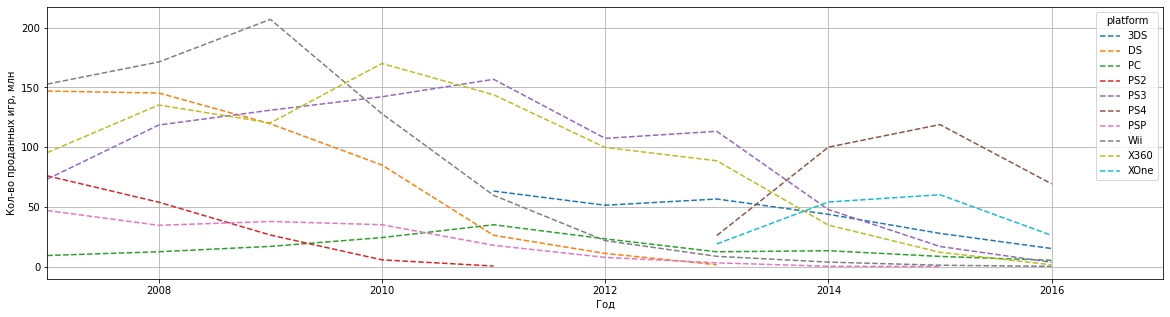

In [15]:
pivot_top_platform = data.query("platform in @top_platform and year_of_release >= 2007").pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
pivot_top_platform.plot(figsize=(20, 5), style='--', grid=True)
plt.xlim(2007, 2017)
plt.xlabel('Год')
plt.ylabel('Кол-во проданных игр, млн')
plt.show()

Как видно из графика выше - самые прибыльные за последние 10 лет платформы(PS3, X360, Wii) теряют свою актуальность продаж падают), зато появились новые платформы (PS4, XOne, 3DS), у которых суммарная выручка меньше, но зато продажи растут.

По 3 наиболее актуальным на данный момент платформам построим бокс-плоты.

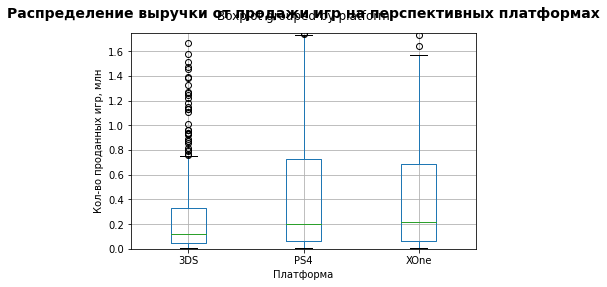

In [16]:
data.query("platform in ['PS4', 'XOne', '3DS']").boxplot(column='total_sales', by='platform')
plt.ylim(0, 1.75)
plt.xlabel('Платформа')
plt.ylabel('Кол-во проданных игр, млн')
plt.title('Распределение выручки от продажи игр на перспективных платформах',
         fontdict={'fontweight':'bold'}, pad=15, size=14)
plt.show()

Из 3 перспективных платформ у XOne самая большая медиана по продажам, немного ей уступает PS4.

Посмотрим для каждой из этих платформ, влияют ли на продажи отзовы пользователей и критиков (есть ли между ними корреляция).

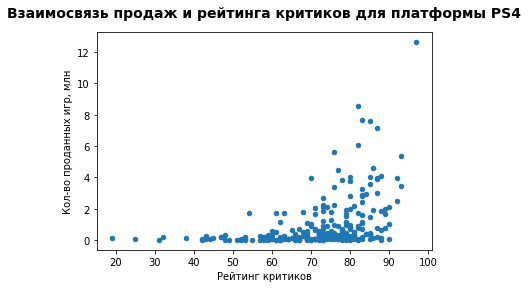

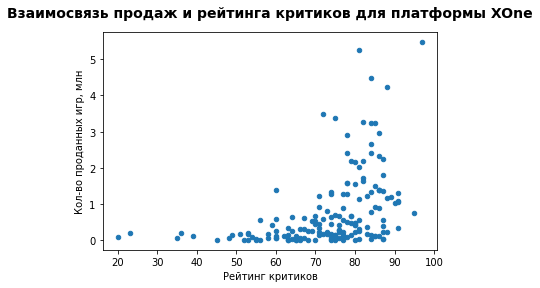

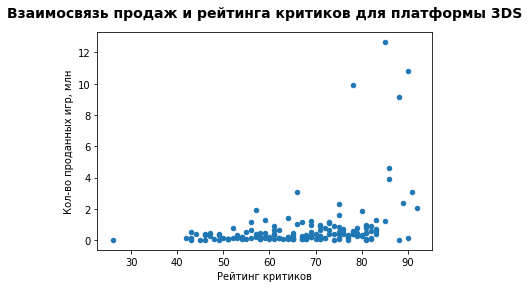

In [17]:
# построим диаграммы рассеяния для каждой платформы 
top_platform = ['PS4', 'XOne', '3DS']

for platform in top_platform:
    data.query('platform == @platform')[['critic_score', 'user_score', 'total_sales']].plot(kind='scatter', x='critic_score', y='total_sales')
    plt.xlabel('Рейтинг критиков')
    plt.ylabel('Кол-во проданных игр, млн')
    plt.title(f'Взаимосвязь продаж и рейтинга критиков для платформы {platform}',
         fontdict={'fontweight':'bold'}, pad=15, size=14)
    plt.show()


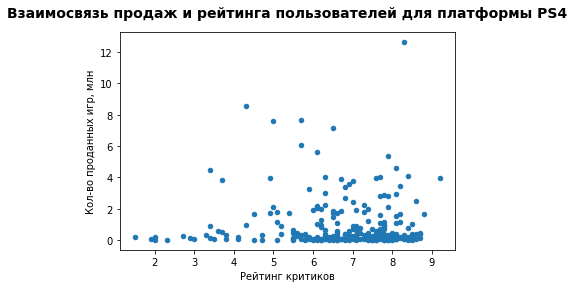

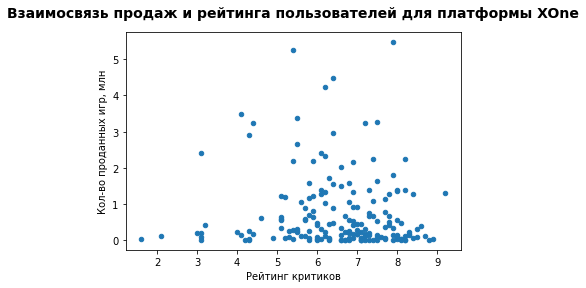

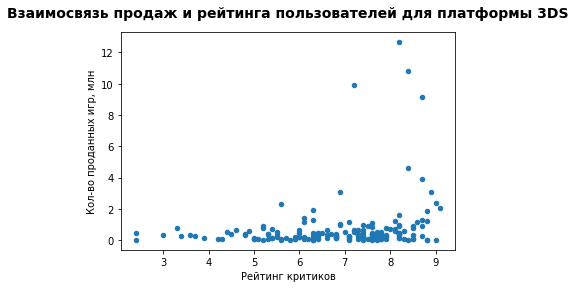

In [18]:
for platform in top_platform:
    data.query('platform == @platform')[['critic_score', 'user_score', 'total_sales']].plot(kind='scatter', x='user_score', y='total_sales')
    plt.xlabel('Рейтинг критиков')
    plt.ylabel('Кол-во проданных игр, млн')
    plt.title(f'Взаимосвязь продаж и рейтинга пользователей для платформы {platform}',
         fontdict={'fontweight':'bold'}, pad=15, size=14)
    plt.show()

In [19]:
# подкрепим полученные выше графики матрицами корреляции
data_corr = data.query('platform == "PS4"')[['critic_score', 'user_score', 'total_sales']].corr()
print('Корреляция между продажами и рейтингом критиков и пользвателей для игр на платформе PS4')
data_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Корреляция между продажами и рейтингом критиков и пользвателей для игр на платформе PS4


,critic_score,user_score,total_sales
critic_score,1.00,0.56,0.41
user_score,0.56,1.00,-0.03
total_sales,0.41,-0.03,1.00


In [20]:
data_corr = data.query('platform == "XOne"')[['critic_score', 'user_score', 'total_sales']].corr()
print('Корреляция между продажами и рейтингом критиков и пользвателей для игр на платформе XOne')
data_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Корреляция между продажами и рейтингом критиков и пользвателей для игр на платформе XOne


,critic_score,user_score,total_sales
critic_score,1.00,0.47,0.42
user_score,0.47,1.00,-0.07
total_sales,0.42,-0.07,1.00


In [21]:
data_corr = data.query('platform == "3DS"')[['critic_score', 'user_score', 'total_sales']].corr()
print('Корреляция между продажами и рейтингом критиков и пользвателей для игр на платформе 3DS')
data_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Корреляция между продажами и рейтингом критиков и пользвателей для игр на платформе 3DS


,critic_score,user_score,total_sales
critic_score,1.00,0.75,0.35
user_score,0.75,1.00,0.22
total_sales,0.35,0.22,1.00


По полученным выше данным можно сделать вывод:
- продажи на платформе 3DS имеют очень слабо выраженную положительную корреляцию с рейтингами критиков и пользвателей, зато рейтинги имеют между собой высокую корреляцию
- продажи на платформе PS4 имеют слабую положительную корреляцию с рейтингом критиков, и не имеют корреляции с рейтингом пользователей
- продажи на платформе XOne также имеют слабую положительную корреляцию с рейтингом критиков, и не имеют корреляции с рейтингом пользователей

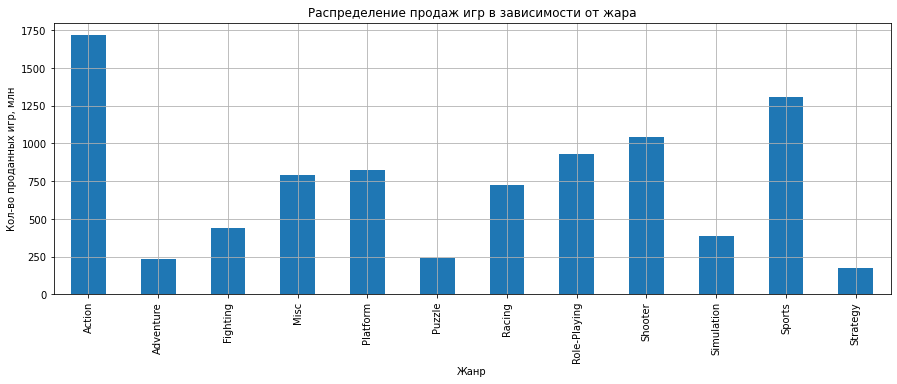

In [22]:
# посмотрим на распределение по жанрам

data.groupby('genre')['total_sales'].sum().plot(kind='bar', figsize=(15, 5), grid=True)
plt.title("Распределение продаж игр в зависимости от жара")
plt.xlabel("Жанр")
plt.ylabel('Кол-во проданных игр, млн')
plt.show()

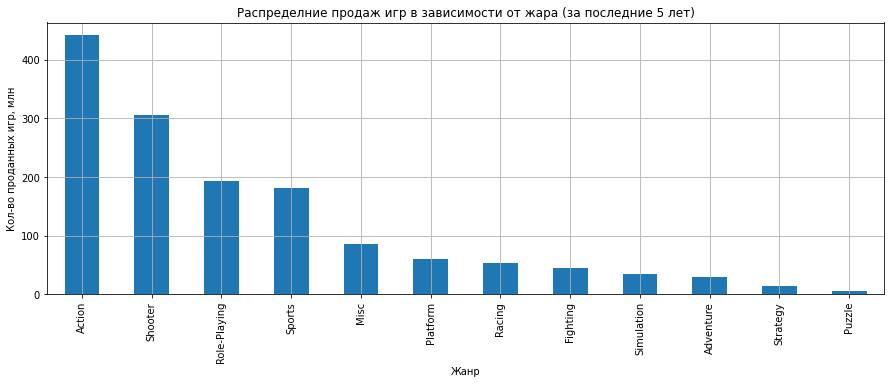

In [23]:
# Посмотрим, изменилось и распределение за последние 5 лет
data.query('year_of_release >= 2012').groupby('genre')['total_sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(15, 5), grid=True)
plt.title("Распределние продаж игр в зависимости от жара (за последние 5 лет)")
plt.xlabel("Жанр")
plt.ylabel('Кол-во проданных игр, млн')
plt.show()

Самым прибыльным жанром является Action(Экшн), на 2-ом месте - спортивные игры, но в последние 5 лет они уступили это место Shooter(стрелялки) и релевым, передвинувшись на 4-ое.

Самые НЕ прибыльные жанры - стратегии, пазлы и приключения.

### Вывод

Проведя исследовательский анализ данных мы пришли к следующим выводам:
- с 1980 по 1993 год игр на рынке выпускалось очень мало и только с 1994 пошел рост, при этом начиная с 2000-х рост ускорился;
- выбраз из всего массива данных 10 самых прибыльных платорм за все время - мы увидели, что цикл жизни платформы ~равен 10 лет. Из-за этого пункта в дальнейшем анализе мы учитывали данные начиная с 2017 года (минус 10 ет от 2017 г.);
- выбрали самые прибыльные за последние 10 лет 10 платформ и увидели, что перспективных из них только 3 - PS4, XOne, 3DS. Несметря на то, что суммарная выручка по этим платформам несколько ниже, чем по другим платформам в топе, их выручка растет, тогда как у других платформ она падает;
- для 3 перспективных платформ построили боксплоты и увидели, что для XOne и PS4 медианная выручка выше, чем для платформы 3DS;
- также для этих 3 платорм мы посчитали корреляцию между отзывами и продажами, и построили диаграммы рассеяния, получив следующие выводы: продажи на платформе 3DS имеют очень слабо выраженную положительную корреляцию с рейтингами критиков и пользвателей, зато рейтинги имеют между собой высокую корреляцию, продажи на платформах PS4 и XOne имеют слабую положительную корреляцию с рейтингом критиков, и не имеют корреляции с рейтингом пользователей;
- мы посмотрели на общее распределение игр по жанрам: самым прибыльным жанром является Action(Экшн), на 2-ом месте - спортивные игры, но в последние 5 лет они уступили это место Shooter(стрелялки) и релевым, передвинувшись на 4-ое. Самые НЕ прибыльные жанры - стратегии, пазлы и приключения.

## Составление портрета пользователя для каждого региона

По очереди рассмотрим каждый регион и выявим для него самые популярные платформы и жанры (за последние 10 лет), а также проанализируем, влияет ли рейтинг ESRB на продажи в этом регионе.

'Топ 5 популярных платформ в Северной Америке'

,platform,na_sales
0,X360,553.68
1,Wii,416.01
2,PS3,381.29
3,DS,273.98
4,PS4,108.74


'Топ 5 наиболее продаваемых жаров в Северной Америке'

,genre,na_sales
0,Action,492.17
1,Shooter,350.11
2,Sports,323.86
3,Misc,259.16
4,Role-Playing,175.41


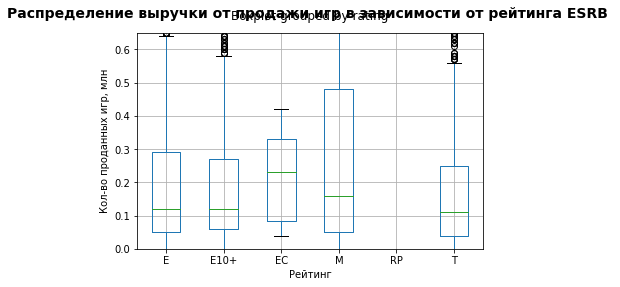

In [24]:
display("Топ 5 популярных платформ в Северной Америке" ,data.query('year_of_release >= 2007').pivot_table(index='platform', values='na_sales', aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False).reset_index(drop=True).head())
print()
display("Топ 5 наиболее продаваемых жаров в Северной Америке" ,data.query('year_of_release >= 2007').pivot_table(index='genre', values='na_sales', aggfunc='sum').reset_index().sort_values(by='na_sales', ascending=False).reset_index(drop=True).head())
print()
data.query('year_of_release >= 2007').boxplot(column='na_sales', by='rating')
plt.ylim(0, 0.65)
plt.xlabel('Рейтинг')
plt.ylabel('Кол-во проданных игр, млн')
plt.title('Распределение выручки от продажи игр в зависимости от рейтинга ESRB ',
         fontdict={'fontweight':'bold'}, pad=15, size=14)
plt.show()

По Северной Америке можно сделать следующие выводы:
- в топ-5 платформ входит только одна, котрую мы ранее обозначили, как перспективную - PS4
- по жанрам распределение аналогично распределению по всей выборке за все время
- наиболее прорадваемые игры входят в категории ЕС(для детей от 3 лет) и М(от 17 лет). Продаются игры всех категрий.


'Топ 5 популярных платформ в Европе'

,platform,eu_sales
0,PS3,319.83
1,X360,257.05
2,Wii,214.70
3,PS4,141.09
4,DS,119.92


'Топ 5 наиболее продаваемых жаров в Европе'

,genre,eu_sales
0,Action,335.67
1,Shooter,230.16
2,Sports,211.49
3,Misc,127.62
4,Racing,104.63


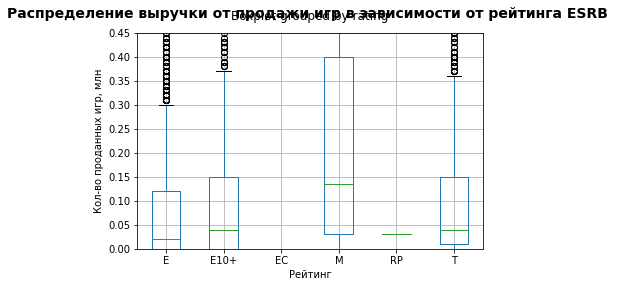

In [25]:
display("Топ 5 популярных платформ в Европе" ,data.query('year_of_release >= 2007').pivot_table(index='platform', values='eu_sales', aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False).reset_index(drop=True).head())
print()
display("Топ 5 наиболее продаваемых жаров в Европе" ,data.query('year_of_release >= 2007').pivot_table(index='genre', values='eu_sales', aggfunc='sum').reset_index().sort_values(by='eu_sales', ascending=False).reset_index(drop=True).head())
print()
data.query('year_of_release >= 2007').boxplot(column='eu_sales', by='rating')
plt.ylim(0, 0.45)
plt.xlabel('Рейтинг')
plt.ylabel('Кол-во проданных игр, млн')
plt.title('Распределение выручки от продажи игр в зависимости от рейтинга ESRB ',
         fontdict={'fontweight':'bold'}, pad=15, size=14)
plt.show()

По Европе делаем следующие выводы:
- в топ-5 платформ входит только одна, котрую мы ранее обозначили, как перспективную - PS4 (также как и в Америке)
- по жанрам распределение пости такое же, как в Америке, но 5 строчку занимаю гонки, а не ролевые игры
- самые продаваемые игры категори М(от 17 лет). При этом мы не видим продаж в категориях ЕС(дети от 3 лет) и Т(подростки)

'Топ 5 популярных платформ в Японии'

,platform,jp_sales
0,DS,102.93
1,3DS,100.62
2,PS3,78.33
3,PSP,66.24
4,Wii,59.13


'Топ 5 наиболее продаваемых жаров в Японии'

,genre,jp_sales
0,Role-Playing,150.55
1,Action,96.29
2,Misc,48.79
3,Sports,40.28
4,Adventure,26.91


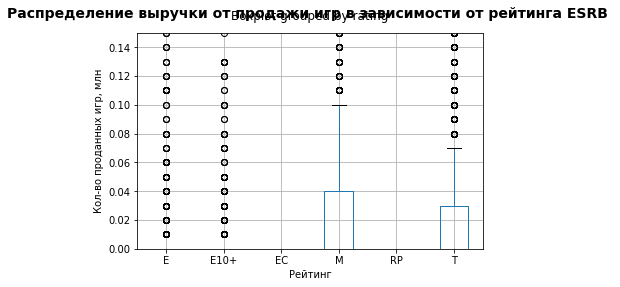

In [26]:
display("Топ 5 популярных платформ в Японии" ,data.query('year_of_release >= 2007').pivot_table(index='platform', values='jp_sales', aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False).reset_index(drop=True).head())
print()
display("Топ 5 наиболее продаваемых жаров в Японии" ,data.query('year_of_release >= 2007').pivot_table(index='genre', values='jp_sales', aggfunc='sum').reset_index().sort_values(by='jp_sales', ascending=False).reset_index(drop=True).head())
print()
data.query('year_of_release >= 2007').boxplot(column='jp_sales', by='rating')
plt.ylim(0, 0.15)
plt.xlabel('Рейтинг')
plt.ylabel('Кол-во проданных игр, млн')
plt.title('Распределение выручки от продажи игр в зависимости от рейтинга ESRB ',
         fontdict={'fontweight':'bold'}, pad=15, size=14)
plt.show()

Данные по Японии отличаются от Европы и Америки:
- в топ-5 платформ входит только одна, котрую мы ранее обозначили, как перспективную - 3DS
- самый популярный жанр - ролевые игры, при этом в рейтинге присутствуют приключения (которые в принципе не популярны, если рассматривать на выборке из все стран)
- продаются игры категорий М и Т. Остальыне категории либо не выходили на рынок в Японии, либо не имеют спроса.

'Топ 5 популярных платформ в дргугих странах '

,platform,other_sales
0,PS3,130.93
1,X360,79.82
2,Wii,64.19
3,PS2,54.46
4,PS4,48.35


'Топ 5 наиболее продаваемых жаров в дргугих странах'

,genre,other_sales
0,Action,126.46
1,Sports,82.44
2,Shooter,81.07
3,Misc,52.32
4,Role-Playing,36.40


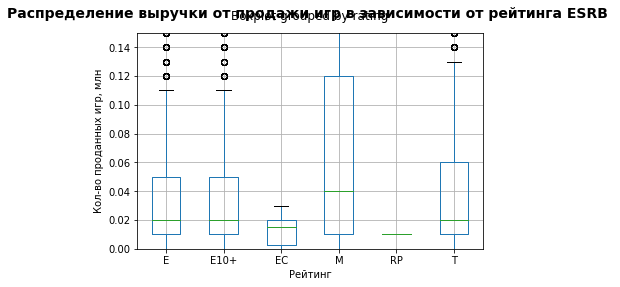

In [27]:
display("Топ 5 популярных платформ в дргугих странах " ,data.query('year_of_release >= 2007').pivot_table(index='platform', values='other_sales', aggfunc='sum').reset_index().sort_values(by='other_sales', ascending=False).reset_index(drop=True).head())
print()
display("Топ 5 наиболее продаваемых жаров в дргугих странах" ,data.query('year_of_release >= 2007').pivot_table(index='genre', values='other_sales', aggfunc='sum').reset_index().sort_values(by='other_sales', ascending=False).reset_index(drop=True).head())
print()
data.query('year_of_release >= 2007').boxplot(column='other_sales', by='rating')
plt.ylim(0, 0.15)
plt.xlabel('Рейтинг')
plt.ylabel('Кол-во проданных игр, млн')
plt.title('Распределение выручки от продажи игр в зависимости от рейтинга ESRB ',
         fontdict={'fontweight':'bold'}, pad=15, size=14)
plt.show()

Данные по продажам игр в других странах очень похожи на распределние по продажам в Еропе и Америке.

### Вывод

Рынки в Северной Америке и Европе похожи, но сильно отличаются от рынка по Японии.

Среди популярных платформ платформ за последние 10 лет, на рынках Европы и Америки присутствует PS4 (которую мы обозначили, как перспективную), а в Японии - 3DS.

В Америке представлены к продаже все категории из рейтинга ESRB, при этом самми прибыльными являются категории ЕС(для детей от 3 лет) и М(от 17 лет). В Европе самыми продаваемыми являются категория М(от 17 лет), и при этом мы не видим продаж в категориях ЕС(дети от 3 лет) и Т(подростки). В Японии продаются только игры категорий М(от 17 лет) и Т(подростки) - остальные игры либо не выходили на рынок, либо не имеют спроса.

Популярные жанры в Америке и Европе совпадают по первым 4 категориям: Экшн, Стрелялки, Спортивные и Прочие, при этом 5 место различается - гонки в Европе и ролевые в Америке.
В Японии самый популярный жанр - Ролевые игры, также в рейтинг попали приключения (5 место). Со 2 по 4 место жары схожи с играми в Америке/Европе, но совсем не представлен жанр стрелялок - либо эти игры не выходят в стране, лио совсем не пользуются популярностью.

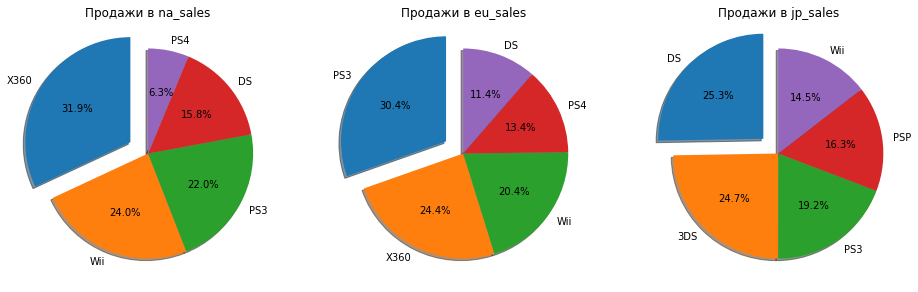

In [28]:
cols = ['na_sales', 'eu_sales', 'jp_sales']
temp = data.query('year_of_release >= 2007').groupby('platform')[cols].sum()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
explode = (0.2, 0, 0, 0, 0)

for i, reg in enumerate(cols):
    top5 = temp[reg].sort_values(ascending=False).head()
    labels = top5.index
    sizes = top5.values
    ax = axs[i]
    ax.set_title(f'Продажи в {reg}')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode, startangle=90) 
    

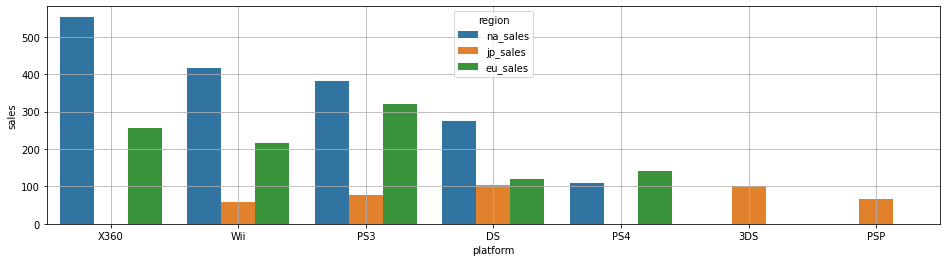

In [29]:
import seaborn as sns

t = temp.reset_index().melt(id_vars='platform', var_name='region', value_name='sales')\
    .sort_values(['region', 'sales'], ascending=False)\
    .groupby(['region']).head(5)

plt.figure(figsize=(16, 4))
sns.barplot(x='platform', y='sales', hue='region', data=t)
plt.grid();

## Проверка гипотез

### Сравнение средних пользовательских рейтингов платформ Xbox One и PC 

Нулевая гипотеза H₀ будет звучить следующим образом: 'Средний пользовательсий рейтинг платформ Xbox One и PC не различается (одинаков)'.

Альтернативная гипотеза H₁: Средний пользовательсий рейтинг платформ Xbox One и PC различается (не одинаков)'

Так как если рейтинги отличаются, но мы не знаем в какую сторону - используем двухстороннюю гипотезу.

In [30]:
# почистим данные от NAN  в столбце user_score
filtred = data[~data['user_score'].isna()]

# сохраним 2 выборки, которые будем сравнивать
XOne_sample = filtred.query('platform == "XOne"')['user_score']
PC_sample = filtred.query('platform == "PC"')['user_score']

alpha = 0.01 # уровень статистической значимости

results = st.ttest_ind(XOne_sample, PC_sample)

# тест двусторонний
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.3037979620149106e-05
Отвергаем нулевую гипотезу


P-значение получилось очень маленьким, значит у нас есть основания отвергать нулевую гипотезу.

### Сравнение средних пользовательских рейтингов жанров Action и Sports

Нулевая гипотеза H₀ будет звучить следующим образом: 'Средний пользовательсий рейтинг жанров Action и Sports не различается (одинаков)'.

Альтернативная гипотеза H₁: Средний пользовательсий рейтинг жанров Action и Sports различается (не одинаков)'

Так как если рейтинги отличаются, но мы не знаем в какую сторону - используем двухстороннюю гипотезу.

In [31]:
# 2 выборки, которые хотим сравнить
Action_sample = filtred.query('genre == "Action"')['user_score']
Sports_sample = filtred.query('genre == "Sports"')['user_score']

alpha = 0.01 # уровень статистической значимости

results = st.ttest_ind(
    Action_sample, 
    Sports_sample)

# тест двусторонний
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.06480928064420527
Не получилось отвергнуть нулевую гипотезу


P-значение получилось выше, чем наше заданное пороговое значение (и даже более 5%) - значит у нас нет оснований отвергать нулевую гипотезу.

### Вывод

Мы проверили 2 гипотезы и пришли к следующим выводам:

- Средний пользовательсий рейтинг платформ Xbox One и PC различается
- У нас нет оснований отвергнуть гипотезу о том, что средний пользовательсий рейтинг жанров Action и Sports одинаков.

## Общие выводы по проекту

В проекте использовалась таблица data с данными из открытых источников. Для её анализа мы подготовили данные: заменили типы, привели названия столбцов к нижнему регистру, удалили строки с пропущенными значениями в стобцах name, genre, year_of_release, оставили пропуски в столбцах critic_score, score_score, rating (чтобы не исказались данные при дальнейшем анализе), добавили дополнительный столбец с суммарными продажами total_sales.

Выявив из данных закономерность, что жизненный цикл платформы состаляет ~10 лет в анализе мы использовали данные только после 2007 года. Выбрав из этого массива самые прибыльные 10 платформ и построив по ним графики распределения выручки - увидели, что самые перспективные на данный момент платформы - PS4, XOne, 3DS. Несметря на то, что суммарная выручка по этим платформам несколько ниже, чем по другим платформам в топе, их выручка растет, тогда как у других платформ она падает. Из этиз 3 перспективных платформ в топе по выручке в Европе и Северной Америке присутствует PS4, а в Японии - 3DS.

В Америке представлены к продаже все категории из рейтинга ESRB, при этом самми прибыльными являются категории ЕС(для детей от 3 лет) и М(от 17 лет). В Европе самыми продаваемыми являются категория М(от 17 лет), и при этом мы не видим продаж в категориях ЕС(дети от 3 лет) и Т(подростки). В Японии продаются только игры категорий М(от 17 лет) и Т(подростки) - остальные игры либо не выходили на рынок, либо не имеют спроса.

Популярные жанры в Америке и Европе совпадают по первым 4 категориям: Экшн, Стрелялки, Спортивные и Прочие, при этом 5 место различается - гонки в Европе и ролевые в Америке. В Японии самый популярный жанр - Ролевые игры, также в рейтинг попали приключения (5 место). Со 2 по 4 место жары схожи с играми в Америке/Европе, но совсем не представлен жанр стрелялок - либо эти игры не выходят в стране, лио совсем не пользуются популярностью.

Подытожим:
- если при выпуске игр мы ориентируемся на аудиторию Европы и Америки, то игру лучше выпускать на платформе PS4. предпочтительные жанры: Action, Shooter, Sports, категория в рейтинге ESRB - М(от 17 лет).
- Другие страные (кроме Японии) очень похожи по продажам на страны Европ и Америки.
- В Японии специфичный вкусы пользователей, если выпускать игры там, то предпочтение стоит отдавать платформе 3DS, жанр выбирать "ролевые игры", категория в рейтинге ESRB - М(от 17 лет) и Т(подростки). При это не стоит выпускать в этой стране игр с жанрами Shooter.